<a href="https://colab.research.google.com/github/andygoosh/wildfire.sberbank.ai/blob/master/workinprogress.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
'''
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
'''
#%load_ext tensorboard

%pylab inline
plt.style.use("bmh")

plt.rcParams["figure.figsize"] = (6,6)

import random as rn
import pandas as pd
import xarray
import requests
import datetime
import numpy as np
from tqdm import tqdm_notebook as tqdm
import sklearn as skl
import seaborn as sns

import tensorflow as tf
from tensorflow import keras

print(tf.__version__)
print(keras.__version__)

from tensorflow.keras import layers
from keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA

import warnings
logger = tf.get_logger()
logger.setLevel(logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.6f}'.format

RS = 77
rn.seed(RS)
#tf.random.set_seed(RS)
np.random.seed(RS)

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  old_rcparam = plt.rcParams["figure.figsize"]
  plt.rcParams["figure.figsize"] = (18,6)


  plt.subplot(1,3,1)
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.plot(hist['epoch'], hist['loss'],
           label='Train Loss')
  plt.plot(hist['epoch'], hist['val_loss'],
           label = 'Val Loss')
  plt.legend()

  plt.subplot(1,3,2)
  plt.xlabel('Epoch')
  plt.ylabel('AUC')
  plt.plot(hist['epoch'], hist['auc'],
           label='Train AUC')
  plt.plot(hist['epoch'], hist['val_auc'],
           label = 'Val AUC')
  plt.legend()
  
  plt.subplot(1,3,3)
  plt.xlabel('Epoch')
  plt.ylabel('Categorical Acc')
  plt.plot(hist['epoch'], hist['categorical_accuracy'],
           label='Train cat.acc.')
  plt.plot(hist['epoch'], hist['val_categorical_accuracy'],
           label = 'Val cat.acc.')
  plt.legend()
  
  plt.show()

  plt.rcParams["figure.figsize"] = old_rcparam


Populating the interactive namespace from numpy and matplotlib


1.15.0
2.2.4-tf


Using TensorFlow backend.


## NCEP Dataset

Погодные данные из проекта [NCEP Reanalysis 2](https://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanalysis2.html) — усреднённые за день температура воздуха, относительная влажность и компоненты ветра. Данные можно получить с 1979 года.

Загрузите наборы данных в каталог `data/ncep/`:
- https://www.esrl.noaa.gov/psd/thredds/fileServer/Datasets/ncep/air.2018.nc
- https://www.esrl.noaa.gov/psd/thredds/fileServer/Datasets/ncep/uwnd.2018.nc
- https://www.esrl.noaa.gov/psd/thredds/fileServer/Datasets/ncep/rhum.2018.nc

In [24]:
!pip3 install scipy

In [38]:
!pip3 install xarray

In [42]:
!pip3 install pydap

     |████████████████████████████████| 2.3MB 2.7MB/s 
     |████████████████████████████████| 122kB 49.5MB/s 


In [41]:
!wget https://www.esrl.noaa.gov/psd/thredds/fileServer/Datasets/ncep/rhum.2018.nc
!wget https://www.esrl.noaa.gov/psd/thredds/fileServer/Datasets/ncep/uwnd.2018.nc
!wget https://www.esrl.noaa.gov/psd/thredds/fileServer/Datasets/ncep/air.2018.nc


--2019-11-23 12:48:35--  https://www.esrl.noaa.gov/psd/thredds/fileServer/Datasets/ncep/rhum.2018.nc
Resolving www.esrl.noaa.gov (www.esrl.noaa.gov)... 140.172.253.69, 2610:20:8800:6001::45
Connecting to www.esrl.noaa.gov (www.esrl.noaa.gov)|140.172.253.69|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46055656 (44M) [application/x-netcdf]
Saving to: ‘rhum.2018.nc’

rhum.2018.nc        100%[===================>]  43.92M  1.09MB/s    in 83s     

2019-11-23 12:49:59 (544 KB/s) - ‘rhum.2018.nc’ saved [46055656/46055656]

--2019-11-23 12:50:01--  https://www.esrl.noaa.gov/psd/thredds/fileServer/Datasets/ncep/uwnd.2018.nc
Resolving www.esrl.noaa.gov (www.esrl.noaa.gov)... 140.172.253.69, 2610:20:8800:6001::45
Connecting to www.esrl.noaa.gov (www.esrl.noaa.gov)|140.172.253.69|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 92099952 (88M) [application/x-netcdf]
Saving to: ‘uwnd.2018.nc’

uwnd.2018.nc        100%[===================>]  87.8

In [47]:
ncep_data = []
year = 2018
for var in ('air', 'uwnd', 'rhum'):
    dataset_filename = '{}.{}.nc'.format(var, year)
    ncep_data.append(xarray.open_dataset(dataset_filename,),)
ncep_data = xarray.merge(ncep_data)

/usr/local/lib/python3.6/dist-packages/xarray/conventions.py:394: SerializationWarning: variable 'air' has multiple fill values {-99, 32767}, decoding all values to NaN.
  stack_char_dim=stack_char_dim)
/usr/local/lib/python3.6/dist-packages/xarray/conventions.py:394: SerializationWarning: variable 'uwnd' has multiple fill values {-99, 32767}, decoding all values to NaN.
  stack_char_dim=stack_char_dim)
/usr/local/lib/python3.6/dist-packages/xarray/conventions.py:394: SerializationWarning: variable 'rhum' has multiple fill values {-99, 32767}, decoding all values to NaN.
  stack_char_dim=stack_char_dim)


## Набор признаков на основе данных NCEP

Ищем наиболее близкий к точке узел сетки в наборе NCEP, в качестве признаков значения переменных зарегистрированные в день регистрации точки и агрегированные показатели за период от 1 до 3х недель до момента регистрации точки.

In [0]:
def extract_features_new(row):
    point = ncep_data.sel(
        lon=row['longitude'],
        lat=row['latitude'],
        level=1000,
        method='nearest',
    )

    date = row['date']
    v = point.sel(time=date)

    PERIODS = [7, 14, 21, 28]
    AGGREGATES = ["mean", "median", "std", "max", "min"]
    all_features = {
        'fire_id': row['fire_id'],
        'fire_type': row['fire_type'],
        'fire_type_name': row['fire_type_name'],
        'date': row['date'], 
        'day': int(date.split('-')[1]),
        'month': int(date.split('-')[2]),
        'longitude': row['longitude'],
        'latitude': row['latitude'],
        'temperature': v.air.values.item(0),
        'humidity': v.rhum.values.item(0),
        'uwind': v.uwnd.values.item(0)
    }

    for period in PERIODS:
        rolling_features = point.rolling(time=period)
        for agg in AGGREGATES:
            agg_function = getattr(rolling_features, agg)
            rolling_result = agg_function().sel(time=date)

            name_t = "_".join(['t', str(period), agg])
            all_features[name_t] = rolling_result.air.values.item(0)

            name_h = "_".join(['h', str(period), agg])
            all_features[name_h] = rolling_result.rhum.values.item(0)

            name_u = "_".join(['u', str(period), agg])
            all_features[name_u] = rolling_result.uwnd.values.item(0)

    return all_features

## Подготовка выборки для обучения

In [177]:
df_train = pd.read_csv('wildfires_train.csv')
df_subsample = df_train.query('(date > "2018") & (date < "2019")').sample(n=2000)

df_features = []
for i, row in tqdm(df_subsample.iterrows(), total=df_subsample.shape[0]):

    features = extract_features_new(row)
    df_features.append(features)

df_features = pd.DataFrame(df_features)
df_features.set_index('fire_id', inplace=True)
df_features.to_csv('fts_preprocessed.cvs', index_label='fire_id')

In [0]:
df_features

## Уменьшаем размерность фичей

fire_type
1      15
2       4
3      70
4     129
5      22
6     407
8     196
9     459
10    460
11    238
Name: fire_type, dtype: int64

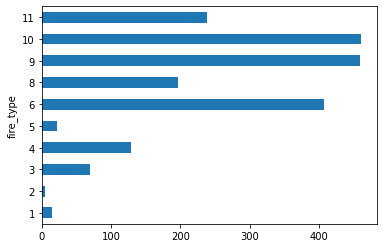

In [283]:
e = y.groupby(y).count()
e.plot.barh()
e

In [0]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold, KFold

X, y = prepare_data(one_hotted=False)
#StratifiedKFold

gb = skl.ensemble.GradientBoostingClassifier()

# "loss":["deviance"]

parameters = { 
    'n_estimators':[300, 400, 500, 700], 
    'learning_rate':[0.03, 0.035, 0.039], 
    'max_depth': [2, 3,4, 5], 
    'min_samples_split': [3, 10, 20, 50],
    "min_samples_leaf": np.linspace(0.1, 0.5, 12),
    "subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
    "max_features":["log2","sqrt"],
    "criterion": ["friedman_mse",  "mae"],
    }

GS = GridSearchCV(gb, parameters, cv=KFold( n_splits = 5, shuffle=True, random_state=RS),verbose=10, n_jobs=-1)
GS.fit(X, y)
print( GS.best_params_ )
print( GS.best_score_ )

Fitting 5 folds for each of 192 candidates, totalling 960 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   30.8s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   59.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed: 10.0min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 13.5min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 16.7min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed: 21.2min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed: 24.9min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed: 30.4min
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed: 36.8min
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed: 44.9min
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed: 53.7min


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


Sequential: CV ROC AUC=0.884


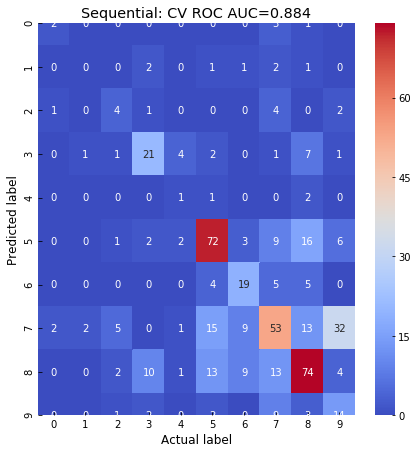

In [184]:
import sklearn.ensemble
import sklearn.model_selection.GridSearchCV

X, y = prepare_data(one_hotted=False)
#X = reduce_dimentions(X)

linear = skl.ensemble.GradientBoostingClassifier(random_state=RS)
#model = skl.ensemble.RandomForestClassifier()
#AdaBoostClassifier

X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size=0.25, random_state=RS)

linear.fit(X_train, y_train)

y_pred = linear.predict_proba(X_cv)

df_predictions = pd.DataFrame(
    y_pred,
    index=y_cv.index,
    columns=[
        'fire_{}_prob'.format(class_id)
        for class_id in linear.classes_
    ],
)

'''
GradientBoostingClassifier: CV ROC AUC=0.663
RandomForestClassifier: CV ROC AUC=0.673
LogisticRegression: CV ROC AUC=0.653
DecisionTreeClassifier: CV ROC AUC=0.597
Sequential: CV ROC AUC=0.732
'''
y_hotted = get_one_hot( y_cv )
draw_confusion_matrix(y_hotted, df_predictions)

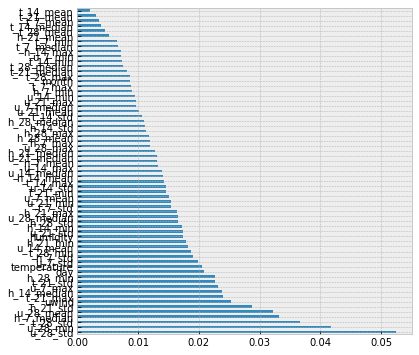

In [179]:
feat_importances = pd.Series(linear.feature_importances_, index=X.columns)
feat_importances.nlargest(100).plot(kind='barh')

###Основной блок

In [0]:
def prepare_data(one_hotted=False):

  df_features = pd.read_csv('fts_preprocessed.cvs', index_col='fire_id')
  FTS = df_features.columns[3:]
  TARGET = 'fire_type'

  columns = [TARGET]

  X = df_features[FTS].fillna(0)
  if one_hotted == True:
    y = get_one_hot( df_features[TARGET] )
  else:
    y = df_features[TARGET]

  return X, y


In [0]:
def reduce_dimentions( X, draw_graph=False ):
  pca = PCA()
  pca.fit(X)
  t = pca.transform(X)

  cols = [f"f{i:d}" for i in range(t.shape[1])]
  X = pd.DataFrame(t, index=X.index, columns=cols)

  if( draw_graph == True):
    feat_importances = pd.Series(pca.explained_variance_, index=X.columns)
    feat_importances.plot(kind='barh')

  return X

In [0]:
def get_one_hot( y ):
  columns=[ 'fire_{}_prob'.format(i) for i in range(1, 12) ]
  columns.remove('fire_7_prob')
  y_ = y.values.reshape(-1,1)
  enc = OneHotEncoder().fit(y_)

  return pd.DataFrame(enc.transform(y_).toarray(), index=y.index, columns=columns)

In [0]:
def draw_confusion_matrix( gt, pred ):
  # get rid of probability, set max prob to 1, erst to 0
  pred_max_prob = pred.apply(lambda row: row.map(lambda e: 1 if e == row.max() else 0), axis = 1)
  # do the trick
  cnf_matrix = skl.metrics.confusion_matrix(pred_max_prob.values.argmax(axis=1), gt.values.argmax(axis=1))
  class_names=pred.columns
  fig, ax = plt.subplots()
  tick_marks = np.arange(len(class_names))
  plt.xticks(tick_marks, class_names)
  plt.yticks(tick_marks, class_names)
  sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="coolwarm" ,fmt='g')
  ax.xaxis.set_label_position("bottom")
  plt.tight_layout()
  plt.title('Confusion matrix', y=1)
  plt.ylabel('Predicted label')
  plt.xlabel('Actual label')

  auc = skl.metrics.roc_auc_score(gt, pred, average='micro')
  str = '{}: CV ROC AUC={:.3f}'.format(type(model).__name__, auc )
  plt.title(str, y=1)
  print(str)

In [0]:
def get_callbacks():
  lr_schedule = keras.callbacks.ReduceLROnPlateau(verbose=0, factor=0.5, patience=49)
  #early_stop = keras.callbacks.EarlyStopping( patience=100, monitor='val_auc', mode='max' ) #, restore_best_weights=True)
  early_stop = keras.callbacks.EarlyStopping( patience=100, monitor='val_loss', mode='min' )
  model_save = keras.callbacks.ModelCheckpoint( "my_checkpoint.h5", monitor='val_loss', save_best_only=True, mode='min' )
            
  return [ early_stop, 
          model_save, 
          #TensorBoard(log_dir='.'),
          #lr_schedule 
          ]

In [0]:
#%tensorboard --logdir .

In [0]:
'''
      layers.Dense(128), #kernel_regularizer=keras.regularizers.l1_l2(0.03, 0.03)),
      #layers.BatchNormalization(),
      layers.Dropout(0.2),
      layers.Dense(64),
      layers.Dropout(0.2),
      layers.Dense(32),
      layers.Dropout(0.1),
'''

def get_model( feature_num, fire_type_num ):
  weight_decay = 0.0005
  model = keras.Sequential([
      layers.Input(shape=[feature_num]),
      layers.Reshape(target_shape=[1, feature_num]),
      layers.LSTM(12, activation='relu', kernel_initializer='random_uniform', kernel_regularizer=keras.regularizers.l2(weight_decay)),
      #layers.LSTM(14, return_sequences=True),
      #layers.LSTM(14),
      layers.Dense(fire_type_num, kernel_initializer='random_uniform', activation='softmax'),
    ])
  optimizer=keras.optimizers.RMSprop(lr=1e-2)
  model.compile(optimizer=optimizer, 
                metrics=[tf.keras.metrics.AUC(), 
                         tf.keras.metrics.categorical_accuracy
                         ], 
                loss=keras.losses.CategoricalCrossentropy() #tf.keras.losses.Huber())
                ) 

  model.summary()
  return model

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 1, 65)             0         
_________________________________________________________________
lstm (LSTM)                  (None, 12)                3744      
_________________________________________________________________
dense (Dense)                (None, 10)                130       
Total params: 3,874
Trainable params: 3,874
Non-trainable params: 0
_________________________________________________________________


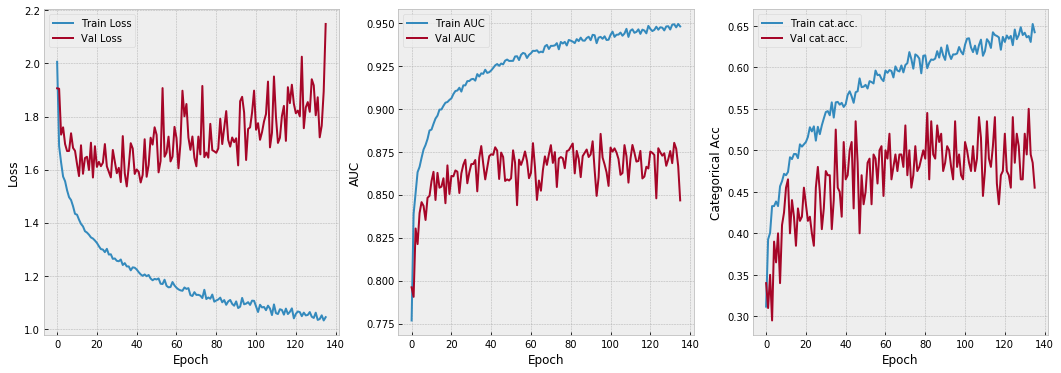

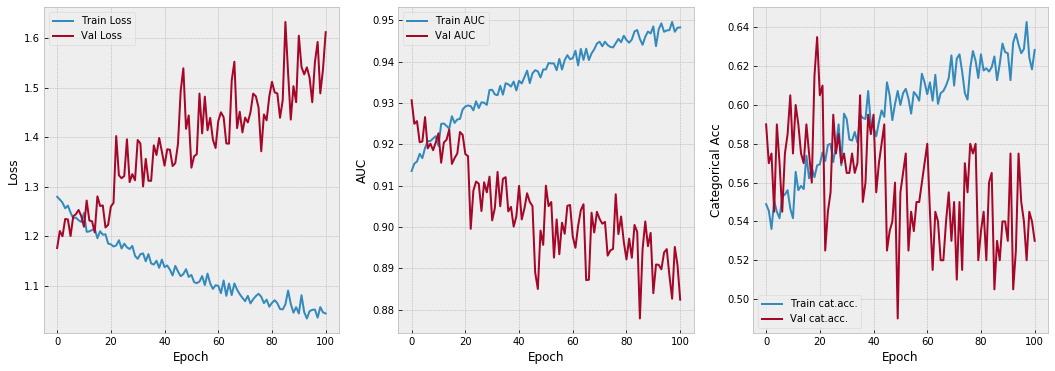

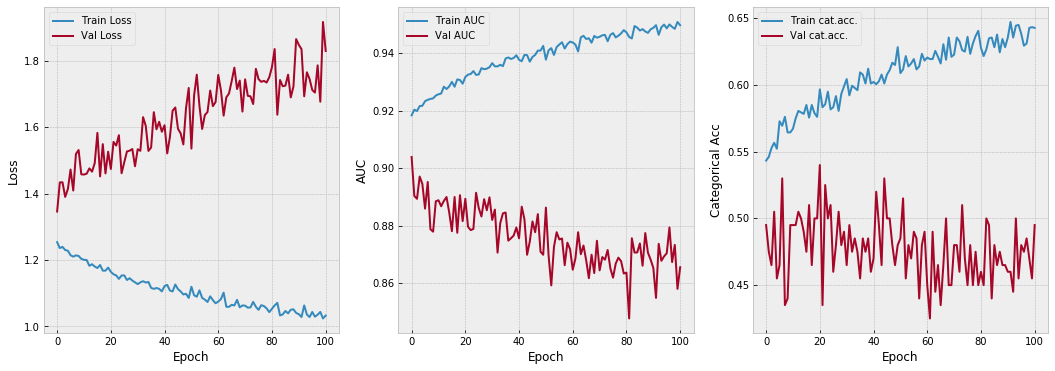

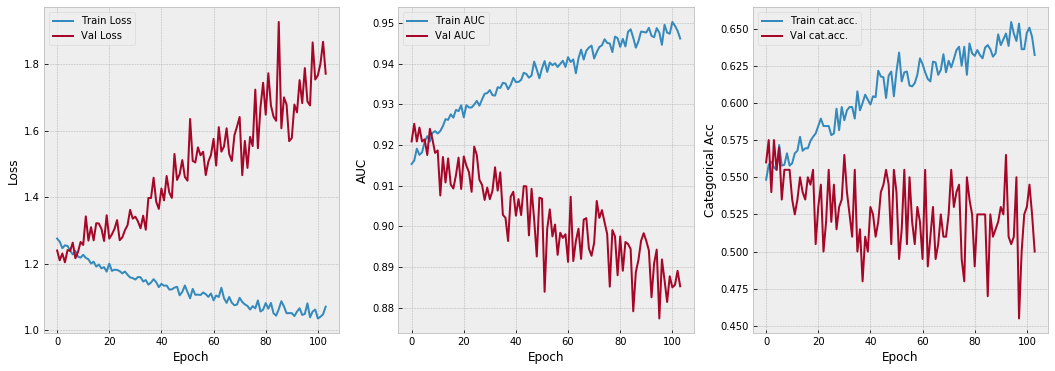

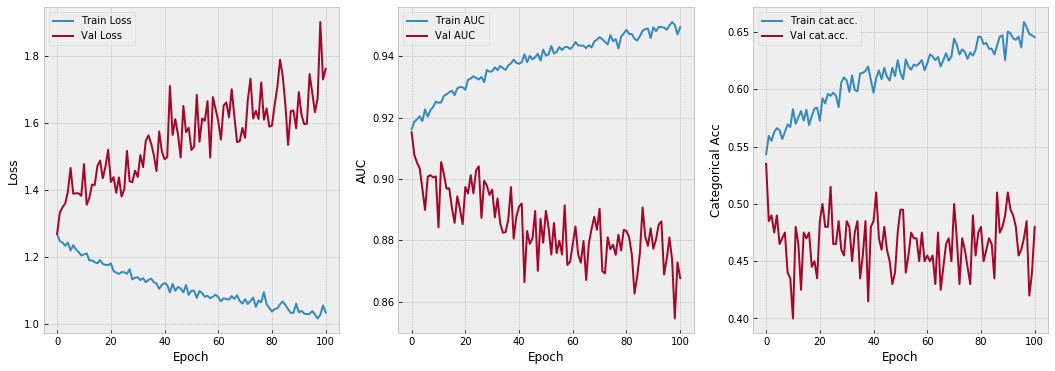

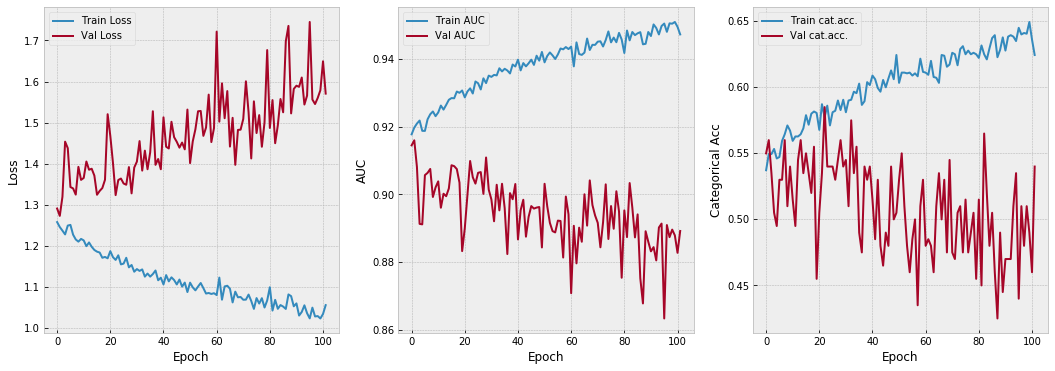

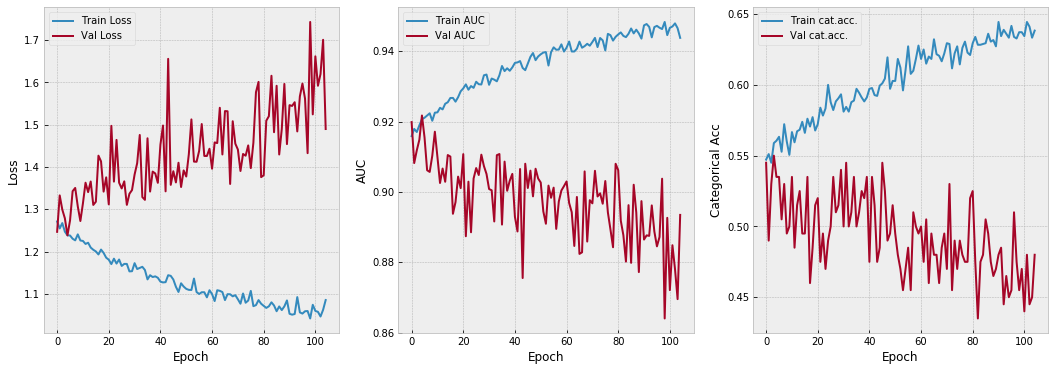

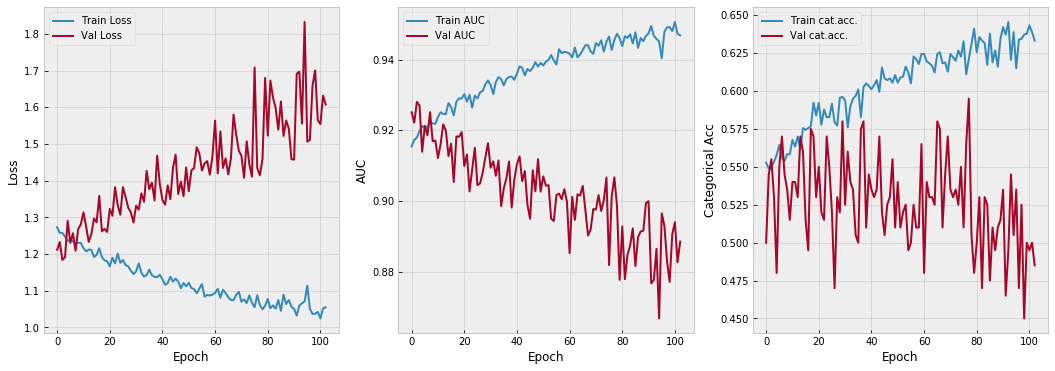

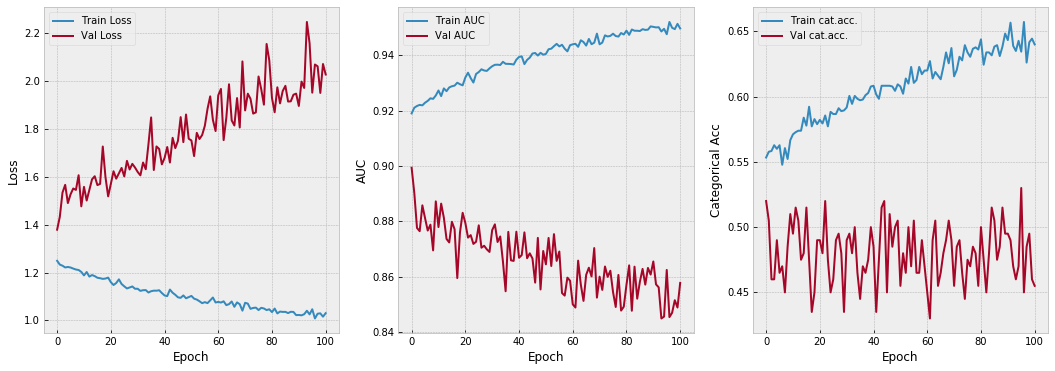

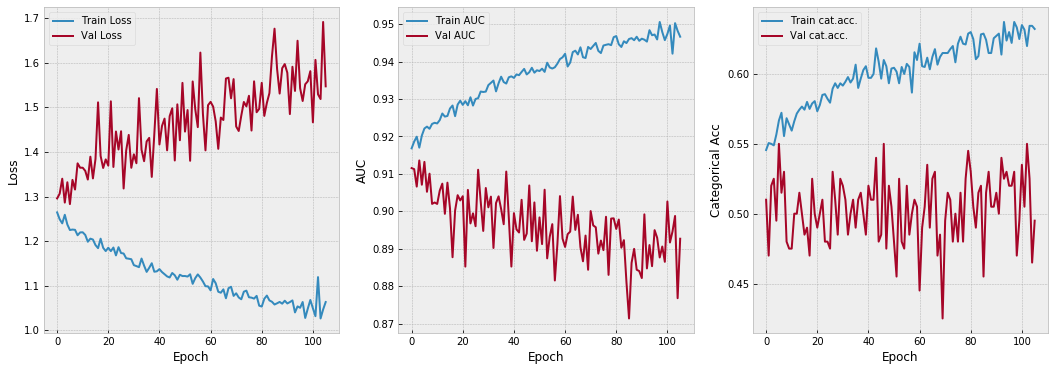

loss: 1.296, AUC: 0.912 Cat.Acc.: 0.538


In [182]:

tf.keras.backend.clear_session()

X, y = prepare_data(one_hotted=True)

EPOCHS = 1000
BS = 256
WINDOW = 0
FOLDS = 10
FEATURES_NUM = X.shape[1]
FIRE_TYPE_NUM = y.shape[1]

model = get_model(FEATURES_NUM, FIRE_TYPE_NUM)
callbacks = get_callbacks()

folds = list(skl.model_selection.KFold(n_splits=FOLDS, shuffle=True, random_state=RS).split(X, y))
for j, (train_idx, val_idx) in enumerate(folds):

  tr_data, cv_data = X.iloc[train_idx], X.iloc[val_idx]
  y_trn, y_cv = y.iloc[train_idx], y.iloc[val_idx]

#if True:
#  tr_data, cv_data, y_trn, y_cv = train_test_split(X, y, test_size=0.25, random_state=RS)

  center, scale = tr_data.mean().values, tr_data.std().values
  trn = (tr_data.values - center)/scale
  cvn = (cv_data.values - center)/scale

  center.tofile('center.bin')
  scale.tofile('scale.bin')

  model.reset_states()
  history = model.fit(trn, y_trn.values,
            epochs=EPOCHS,
            batch_size=BS,
            shuffle=True,
            use_multiprocessing=True,
            verbose=0,
            validation_data=(cvn, y_cv.values),
            callbacks=callbacks)
  model = keras.models.load_model('my_checkpoint.h5')

  plot_history(history)

  score = model.evaluate(trn, y_trn.values, 
                          batch_size=BS, 
                          verbose=0,
                          use_multiprocessing=True)
  
print('loss: {:.3f}, AUC: {:.3f} Cat.Acc.: {:.3f}'.format(*score))

#model = tf.keras.models.load_model('my_checkpoint.h5')
model.reset_states()

loss: 1.279, AUC: 0.915 Cat.Acc.: 0.544
tr: ROC AUC=0.915
cv: ROC AUC=0.905
Sequential: CV ROC AUC=0.905


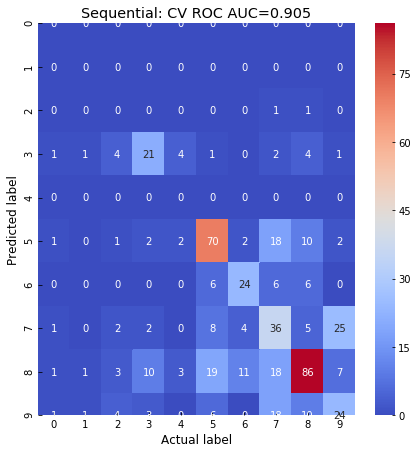

In [183]:
tr_data, cv_data, y_trn, y_cv = train_test_split(X, y, test_size=0.25, random_state=RS)

trn = (tr_data.values - center)/scale
cvn = (cv_data.values - center)/scale

tr_preds = pd.DataFrame(model.predict(trn, use_multiprocessing=True), index=y_trn.index, columns=y_trn.columns)
cv_preds = pd.DataFrame(model.predict(cvn, use_multiprocessing=True), index=y_cv.index, columns=y_cv.columns)

score = model.evaluate(trn, y_trn.values, 
                         batch_size=BS, 
                         verbose=0,
                         use_multiprocessing=True)
print('loss: {:.3f}, AUC: {:.3f} Cat.Acc.: {:.3f}'.format(*score))

auc_trn = skl.metrics.roc_auc_score(y_trn, tr_preds, average='micro')
auc_cv = skl.metrics.roc_auc_score(y_cv, cv_preds, average='micro')
print('tr: ROC AUC=%.3f' % (auc_trn))
print('cv: ROC AUC=%.3f' % (auc_cv))

draw_confusion_matrix( y_cv, cv_preds)

In [34]:
#df_features[TARGET].groupby(df_features[TARGET]).count() , index=

vals = [ y_cv.iloc[:,i].sum() for i in range(y_cv.shape[1]) ]
pd.DataFrame(vals, index=y_cv.columns, columns=['count']).plot.barh();
plt.title('Fire Type Counts in cv', y=1)

IndexError: ignored

In [35]:
#auc_cv = skl.metrics.roc_auc_score(y_cv, cv_preds)
print( cv_preds.iloc[0].sum() )
a = tr_preds.apply(lambda row: row.map(lambda e: 1 if e == row.max() else 0), axis = 1)
a, y_cv

1.0


(         fire_1_prob  fire_2_prob  ...  fire_10_prob  fire_11_prob
 fire_id                            ...                            
 138567             0            0  ...             0             0
 142911             0            0  ...             0             0
 155147             0            0  ...             0             0
 153210             0            0  ...             0             1
 147445             0            0  ...             0             0
 ...              ...          ...  ...           ...           ...
 145579             0            0  ...             0             0
 146406             0            0  ...             0             0
 147343             0            0  ...             0             0
 140644             0            0  ...             0             0
 149812             0            0  ...             0             0
 
 [1500 rows x 10 columns], fire_id
 142953     6
 150822    10
 142310     9
 137261    10
 141065    11
         

In [36]:
all_pred = pd.DataFrame(model.predict(trn, use_multiprocessing=True), index=y_trn.index, columns=y_trn.columns)

draw_confusion_matrix(y_trn, all_pred)

TypeError: ignored

In [31]:
df_features[TARGET].groupby(df_features[TARGET]).count().plot.barh()

NameError: ignored

Test loss: 1.6663
Test accuracy: 0.1546


Text(0, 0.5, 'predicted activity')

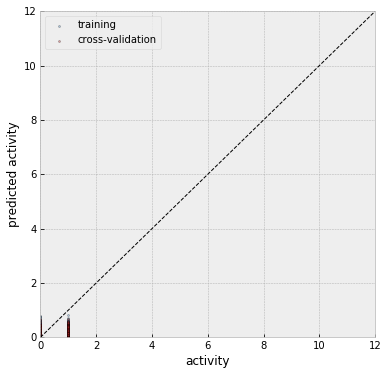

In [225]:
score = model.evaluate(trn, y_trn.values, verbose=0)
print('Test loss: {:.4f}'.format(score[0]))
print('Test accuracy: {:.4f}'.format(score[1]))

plt.scatter(y_trn.values, tr_preds, s=4, alpha=0.4, edgecolor="k", c="steelblue", label="training")
plt.scatter(y_cv.values, cv_preds, s=4, alpha=0.4, edgecolor="k", c="firebrick", label="cross-validation")

plt.xlim(0, 12)
plt.ylim(0, 12)
plt.legend(loc=0)
plt.plot([0, 12], [0, 12], "--", c="k", linewidth=1)
plt.xlabel("activity")
plt.ylabel("predicted activity")

In [226]:
for i in range(5):
  ind = np.int( np.random.random_sample() * tr_preds.shape[0] )
  print( tr_preds.iloc[ind].argmax(), y.iloc[ind].argmax() )

fire_10_prob fire_9_prob
fire_8_prob fire_9_prob
fire_9_prob fire_10_prob
fire_6_prob fire_10_prob
fire_10_prob fire_4_prob


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


## Решение для отправки в систему

In [0]:
import pickle

with open('model.pickle', 'wb') as fout:
    pickle.dump(linear, fout, protocol=pickle.HIGHEST_PROTOCOL)

In [0]:
df_predictions.to_csv('sample_predictions.csv', index_label='fire_id')